<h1>A Preliminary Investigation into the Factors that Influenced the Survivability of the Sinking of the Titanic.</h1>

By John Ingles

April 9th, 2017

## Introduction

In this notebook, I'll investigate a dataset containing passenger data from the Titanic's first and last voyage.

## Dataset

I'll begin my analysis by taking a look at the dataset in question provided by [Kaggle](https://www.kaggle.com/c/titanic/data).

It contains 891 observations of 12 passenger variables:
 
  * `PassengerId`:  A unique number identifying the passenger
  * `Survived`:  Survival status of the passenger (survival = 1, non-survival = 0)
  * `Pclass`:  The ship class of which the passenger was a member (1 = First, 2 = Second, 3 = Third)
  * `Name`:  The passenger's name
  * `Age`:  The passenger's age in years
  * `SibSp`:  The number of siblings and spouses the passenger had aboard the ship
  * `Parch`:  The number of parents and children the passenger had aboard the ship
  * `Ticket`:  The passenger's ticket number
  * `Fare`:  The fare the passenger paid for their ticket
  * `Cabin`:  The number of the cabin the passenger stayed in
  * `Embarked`:  The port that the passenger embarked from (C = Cherbourg, Q = Queenstown, S = Southampton)
  
## Problem Statement and Methods

I decided to look into the question of "What factors most influenced a passenger's chances of survival?".

For this analysis, I'm going to focus on the following data points as I hypothesize that they will be the most important factors affecting survival:
* Survival Status
* Passenger Class
* Sex
* Age

I'll begin by exploring the variables, their relationships, and looking at mean values for each category to determine some initial trends.  Next, I'll compute the percent survived counts for the different categories and create some figures to display them.  Finally, I'll use the `statsmodels.api` module to perform a maximum likelihood estimation (MLE) with the logit model to determine the odds of survival for each group.

## Import Modules

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns

## Data Pre-Processing
I'll first load the dataset into a pandas dataframe.

In [2]:
#load dataset
titanic_data = pd.read_csv('titanic-data.csv')

## Data Cleaning

An investigation into the dataset reveals that not all of the entries have a recorded age.

In [3]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I'll drop these entries in order to carry out the analysis without errors.

In [4]:
titanic_data_age_cleaned = titanic_data.dropna(subset=["Age"])

## Data Exploration

First, I'll use a pairplot of the variables to show their relationships to each other.  This will be important for determining if various survival statistics are because of a true correlation or are down to the relationships between the variables.  For example, say there are more women in third class than any other class and third class happens to have the worst survival rates. Then, a slight preference for women being chosen for first access to the lifeboats, leading to better survival rates for women, might be rendered less apparent by their abundance in third class.

In [5]:
%matplotlib inline

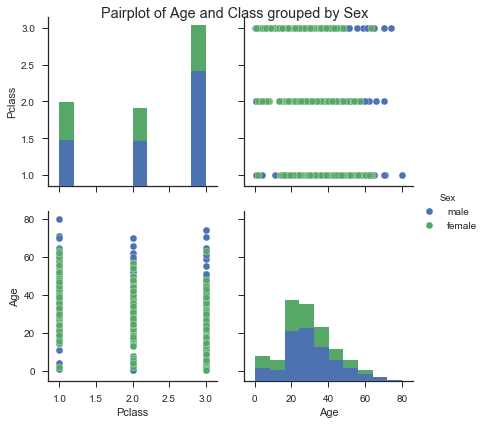

In [6]:
sns.set(style="ticks", color_codes=True)

sns.pairplot(titanic_data_age_cleaned, vars= ("Pclass","Age"), size=3, hue="Sex")
plt.suptitle("Pairplot of Age and Class grouped by Sex");

A number of observations can be made here.  First, it can be noted that the distribution of men and women was about even in first and second class, but not in third class where men outnumbered women.  Also, the number of people in general was higher in third class than in the others.  The age distribution of the passengers has few people under 20 and most people in the range of 20-30, after which the number of people in the older ranges steadily decreases.  The age distributions of people in each class show what appears to be younger people on average in the lower classes and older people in the higher classes, but the graphs are not well suited to showing these distributions.  Let's refine the graphs.  A kernel density plot will better show the age distribution onboard and a violin plot will show the age distributions within each class more clearly.

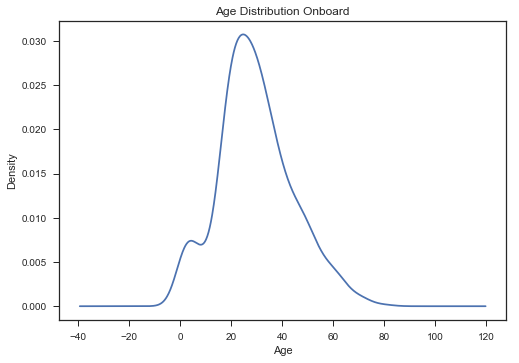

In [7]:
#plots a kernel density estimate of the passengers' age
titanic_data.Age.plot(kind='kde')
plt.title("Age Distribution Onboard")
plt.xlabel("Age");

The age distribution of those on board is skewed to the left (younger) with a small bump around the age of children and infants.

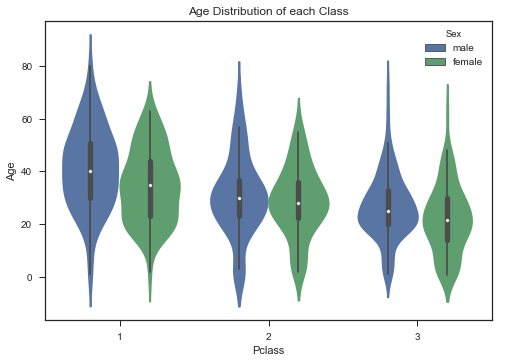

In [8]:
sns.violinplot(x="Pclass",y="Age", hue="Sex", data=titanic_data, dropna=True)
plt.title("Age Distribution of each Class");

There definitely seems to be a tendency for younger people to be in a lower class and older people to be in a higher class.  This is, perhaps, due to older passenger's having more wealth on average.

I'll finish up the examination of the variables by printing their mean values.

In [31]:
def means_grouped_by_x(data, x):
    return data.groupby(x).mean()    

In [33]:
means_grouped_by_x(titanic_data,"Pclass")

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [34]:
means_grouped_by_x(titanic_data, "Sex")

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


In [35]:
means_grouped_by_x(titanic_data,"Survived")

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


Looking at these values we can again see the relationship between age and class.  We can also see no dicernible relationship between age and sex.

Considering the relationships between the variables and the statistics, I decided on some reasonable hypotheses about survivability to test:
1. Class was positively correlated with survival
2. Women were more likely to survive than men
3. Younger people were more likely to survive than older people

## Data Visualization

To investigate these hypotheses, I'll look at the survival percentages in each category in an attempt to control for the uneven membership numbers between them.

I'll start by looking at the survival percentages for each passenger class.

In [12]:
class_total = pd.crosstab(titanic_data.Pclass, titanic_data.Survived)
class_surv = pd.crosstab(titanic_data.Pclass, titanic_data[titanic_data.Survived==1].Survived)
class_surv.div(class_total.sum(1).astype(float), axis=0).multiply(100)

Survived,1.0
Pclass,
1,62.962963
2,47.282609
3,24.236253


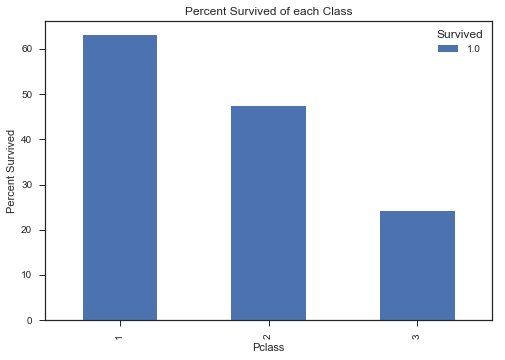

In [13]:
class_surv.div(class_total.sum(1).astype(float), axis=0).multiply(100).plot(kind='bar');
plt.title("Percent Survived of each Class")
plt.ylabel("Percent Survived");

We can see about survival rates of about:
* 63% for 1st class
* 47% for 2nd class
* 24% for 3rd class

This correlation between class and survivabilty could be due to a preference of the crew to save the wealthy passengers over the poor ones or due to the fact that 1st class cabins were closer to the deck and would be evacuated first.

We saw earlier that there were more men in third class than in first or second.  It could be that a high male death rate could lower the survival rate in third class all by itself and indeed the rate is low as shown below.

In [14]:
sex_total = pd.crosstab(titanic_data.Sex, titanic_data.Survived)
sex_surv = pd.crosstab(titanic_data.Sex, titanic_data[titanic_data.Survived == 1].Survived)
sex_surv.div(sex_total.sum(1).astype(float), axis=0).multiply(100)

Survived,1.0
Sex,
female,74.203822
male,18.890815


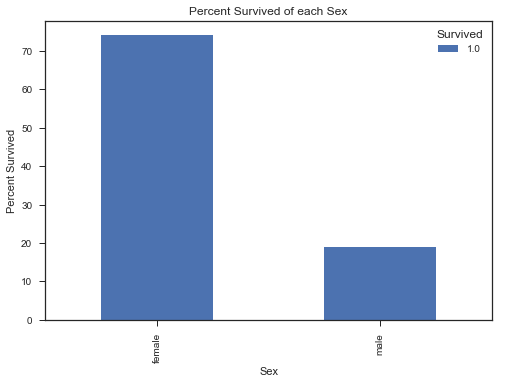

In [15]:
sex_surv.div(sex_total.sum(1).astype(float), axis=0).multiply(100).plot(kind='bar')
plt.title("Percent Survived of each Sex")
plt.ylabel("Percent Survived");

We can see survival rates of about:
* 74% for females
* 19% for males

So, let's further break the graph down by sex to see if the negative correlation can be explained by high male death rates biasing third class.

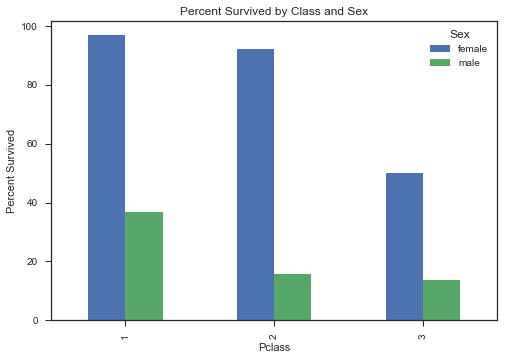

In [16]:
survivors_group = titanic_data[titanic_data.Survived == 1]

class_sex_total = pd.crosstab(titanic_data.Pclass, titanic_data.Sex)
class_sex_survivors = pd.crosstab(survivors_group.Pclass, survivors_group.Sex)

class_sex_survivors.div(class_sex_total, axis=0).multiply(100).plot(kind='bar')
plt.title("Percent Survived by Class and Sex")
plt.ylabel("Percent Survived");

From this figure, it appears that a passenger's gender was a greater influence on their survival than their class but there is still a noticeable positive correlation between class and survivability for both genders.  It is then likely that each variable had its own distinct effect, class for the reasons proposed before and sex likely due to the well-known order of "Women and Children First" when loading the lifeboats.

We've gained some support for each of the hypotheses.  As a final test, I'll perform a logistical regression using Class and Sex as categorical variables and Age as a continuous variable.

## Logistic Regression

In [17]:
#define variables for Logit, C indicates categorical variables and variable to the left of ~ indicates the dependant variable
formula = 'Survived ~ C(Pclass) + C(Sex) + Age'

# create a regression friendly dataframe using patsy's dmatrices function
y,x = dmatrices(formula, data=titanic_data_age_cleaned, return_type='dataframe')

# instantiate our model
model = sm.Logit(y,x)

# fit our model to the training data
results = model.fit()

#print result summary
print (results.summary())
print ("\n")
print ('Change in odds of survival for a one unit change in parameter')
params = results.params
conf = results.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.453279
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Sun, 14 May 2017   Pseudo R-squ.:                  0.3289
Time:                        04:02:44   Log-Likelihood:                -323.64
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 2.074e-67
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.7770      0.401      9.416      0.000       2.991       4.563
C(Pclass)[T.2]   

The regression successfully converged after 6 iterations.  The changes in odds of survival between each category are summarized below as 95% confidence intervals:
* 2nd class is predicted to have about 15.65% - 46.54% as many survivors as 1st class
* 3rd class is predicted to have about 4.36% - 13.15% as many survivors as 2nd class
* Men are predicted have about 5.34% - 12.05% as many survivors as women
* Someone of age n is predicted to have about 94.93% - 97.83% as many survivors as someone of age n-1

## Conclusion

The means, percent survival counts of each category, and logistic regression all lend credence to the hypotheses for survival trends.  However, the statistics drawn from this investigation are still very rough and can't be used to imply causation.  The pseudo r-squared of the logistic regression was only 0.3289 indicating that the model accounted for relatively little of the variability of the data.  Also, it should be noted that the 95% confidence intervals are very wide for some parameters.  

This analysis had several limitations.

The data was modified by the removal of 177 passengers who had no recorded age.  This could have altered the distributions of variables in a significant way.  It might have been fixable by replacing the missing ages with the median values for each class-sex group or with values from uniform distributions around the medians, but I chose not to because I wanted to preserve the authenticity of the data.

This analysis stopped short of a full statistical test of significance for the correlations found because I intended this to be a mere introduction of the dataset and its trends.  Anyone going further should look to patch up the missing values as best they can and run a chi-square test for independence for Sex vs. Survival and Class vs. Survival.  Also, a more robust regression would benefit from incorporating non-linearity and interaction terms between the variables.

## References

1. For the general structure of a report of this type http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

2. For help in using the Logit method http://blog.yhat.com/posts/logistic-regression-and-python.html